# Modeling a "phase diagram" of superposition.

This notebook is meant to explore some exact, explicit models for superposition,
which relate to the phase diagram at https://transformer-circuits.pub/2022/toy_model/index.html



# Goal of the models

In the toy learned models described in the paper, we see that there is a clear pattern—a "phase diagram"—of the type of superposition. The pattern depends on the sparsity of the training data and the relative weights of different coordinates in the loss function.

The goal of this notebook is to define a set of very simple prototype neural networks, and show analytically that they produce a similar phase diagram.

# Task specification

Our task will be to create an autoencoder mapping a vector in $\mathbb{R}^n$ to itself via a subspace with one lower dimension. We're interested in two parameters: how the sparsity of vectors in training data affect the loss, and how changing the importance of a single coordinate affects the results.

Setting **dim** controls the dimension of the space we're working in.
In practice, this doesn't seem to make a big qualitative difference.

If you're playing with this notebook for the first time, try setting dim=3,
and then in the parameter sweep cell, set a low number of steps.

In [ ]:
import math
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# Dimension of input vector.
dim = 3


# Four explicit models

This section defines four toy autoencoders, each of the form
$y = \text{ReLU}(W^tWx + b)$, where $\text{ker}(W)$ has dimension 1. You can think of these as special neural network autoencoders with a bottleneck layer of one dimension less than the input and output layers.

<br>

The autoencoders are designed to reproduce vectors in $\mathbb{R}^n$, drawn from a special distribution. Each coordinate is independently chosen to be either uniform random in $[0, 1]$ (with probability $s$)  or simple $0$ (with probability $1-s$). The parameter $s$ is called the **sparsity**.

To measure loss between a target $x = (x_1, \ldots, x_n)$ and its reconstruction $y = (y_1, \ldots, y_n)$, we're using a weighted squared error:

loss = $(x_1 - y_1)^2 + (x_2 - y_2)^2 + \ldots + (x_{n-1} - y_{n-1})^2 + r(x_n - y_n)^2$

The factor of $r$ on the last term is called the **relative weight**.

<br>

To define the models, we consider two ways of mapping to a lower-dimensional space: either simply ignoring a coordinate, or combining ("superimposing") two coordinates. We also consider two possibilities for each: the last, specially weighted coordinate is mapped to a lower-dimensional space, or it is not.

<br>

Concretely, Let $P_2 = \begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix}$. Geometrically, this is a projection orthogonal to $(1, 1)$ scaled by $\sqrt{2}$. Informally, we can think of this as modeling a simple kind of superposition among two coordinates.

Let $I_n$ be the identity matrix on $\mathbb{R}^n$.
<br><br>


Consider the following linear transformations from $\mathbb{R}^n \to \mathbb{R}^{n}$.

Let $D_{first} = (0) \oplus I_{n-1}$ be the orthogonal projection that just discards the first coordinate, setting it to zero.

Let $D_{last} = I_{n-1} \oplus (0)$ be the orthogonal projection that just discards the last coordinate, setting it to zero.

Let $S_{first} = P_2 \oplus I_{n-2}$, modeling a superposition among the first two coordinates.

Let $S_{last} = I_{n-2} \oplus P_2 $, modeling a superposition among the last two coordinates.

Each of these is a symmetric positive semi-definite rank $n-1$ matrix, and so each can be written as $W^tW$ for some $W: \mathbb{R}^n \to \mathbb{R}^{n-1}$.

<br>

For a given sparsity parameter $s$, we will consider four tiny "neural networks." The first two include small bias terms that reflect the expected value of the coordinate being discarded. (Here $e_1$ and $e_n$ are the first and last basis vectors.)

$f_s(x) = \text{ReLU}(D_{first}x  + \frac{\displaystyle s}{\displaystyle 2}e_1)$

$g_s(x) = \text{ReLU}(D_{last}x  + \frac{\displaystyle s}{\displaystyle 2}e_n)$

$h_{first}(x) = \text{ReLU}(S_{first}x)$

$h_{last}(x) = \text{ReLU}(S_{last}x)$








# Calculating Expected Loss



We can calculate the expected value of this loss explicitly for these tiny networks. For $f_s$ and $g_s$ we need only look at the discarded coordinate. With probability $1-s$ the loss will be the square of the bias term, and with probability $s$ can be worked out as simple integral:

$$
\text{loss}(f_s) = E[f_s(x) - x] = (1-s)\big(\frac{s}{2}\big)^2 + s\int_{0}^{1} (x - \frac{s}{2})^2 \, dx = 
\frac{s}{3} - \frac{s^2}{4}
$$

$$\text{loss}(g_s) = r \, \text{loss}(f_s) = r(\frac{s}{\displaystyle 3} - \frac{s^2}{4})$$

The networks $h_{first}$ and $h_{last}$ reconstruct vectors perfectly unless both of their superimposed coordinates are non-zero; this happens with probability $s^2$. The matrix $P_2$ sends $(x, y)$ to $(x - y, y - x)$, which has reconstruction error $2 \min(x, y)^2$ when both coordinates have loss weighted with 1, and error $(1 + r)\min(x, y)^2$ when one coordinate has weight $r$. This implies

$$\text{loss}(h_{first}(x)) = 2 s^2 \int_{0}^{1} \int_{0}^{x} 2y^2 \, dy \, dx = \frac{ s^2}{ 3}$$

$$\text{loss}(h_{last}(x)) = 2 s^2 \int_{0}^{1} \int_{0}^{x} (1 + r)y^2 \, dy \, dx = \frac{ (1 + r) s^2}{ 6}$$




In [ ]:
# Define explicit expressions for expected loss

def loss_f(r, s):
  return s / 3 - s * s / 4

def loss_g(r, s):
  return r * loss_f(r, s)

def loss_h_first(r, s):
  return s * s / 3

def loss_h_last(r, s):
  return (1 + r) * s * s / 6

# A "phase" diagram of optimal models

For each value of the sparsity $s$ and relative weight $r$, we can ask which of these models is best. The code below creates a plot that answers this question.



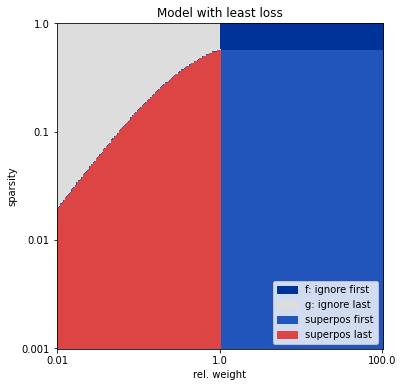

In [ ]:
def interpolate(a, b, n):
  return a + (b - a) * n / (steps - 1)

# Number of steps for each parameter
steps = 200

# Set start and end points for parameter sweep
log_weight_start = -2
log_weight_end = 2
log_sparsity_start = 0
log_sparsity_end = -3

# Create a matrix of losses for each model
explicit_loss = np.zeros((steps, steps, 4))
log_sparsities = np.zeros((steps, steps))
log_weights = np.zeros((steps, steps))
for i in range(steps):
  log_sparsity = interpolate(log_sparsity_start, log_sparsity_end, i)
  sparsity = 10 ** log_sparsity
  for j in range(steps):
    log_weight = interpolate(log_weight_start, log_weight_end, j)
    rel_weight = 10 ** log_weight
    log_sparsities[i][j] = log_sparsity
    log_weights[i][j] = log_weight
    explicit_loss[i, j, 0] = loss_f(rel_weight, sparsity)
    explicit_loss[i, j, 1] = loss_g(rel_weight, sparsity)
    explicit_loss[i, j, 2] = loss_h_first(rel_weight, sparsity)
    explicit_loss[i, j, 3] = loss_h_last(rel_weight, sparsity)

# Identify the model with least loss for each parameter configuration
model_with_least_explicit_loss = np.argmin(explicit_loss, axis=2)

# Create labels for the functions
function_labels = ['f: ignore first', 'g: ignore last', 'superpos first', 'superpos last']

# Plot the "phase diagram"
def add_log_ticks():
  def make_log_ticks(a, b, n):
    scale = np.arange(0, n) / (n - 1)
    labels = 10 ** (b * scale + a * (1 - scale))
    ticks = scale * (steps - 1)
    return (ticks, labels)
  (ticks, labels) = make_log_ticks(log_weight_start, log_weight_end, 3)
  plt.xticks(ticks = ticks, labels = labels)
  plt.xlabel("rel. weight")
  (ticks, labels) = make_log_ticks(log_sparsity_start, log_sparsity_end, 4)
  plt.yticks(ticks = ticks, labels = labels)
  plt.ylabel("sparsity")
def show_phase_matrix(matrix, cmap, title):
  plt.figure(figsize=(6, 6))
  plt.title(title)
  heatmap = plt.imshow(matrix, cmap=cmap, vmin=0, vmax=3)
  add_log_ticks()
  handles = [mpatches.Patch(color=cmap(i), label=function_labels[i]) for i in range(4)]
  plt.legend(handles=handles, loc='lower right')
  plt.show()

function_colors = colors.ListedColormap(['#039', '#ddd','#25b', '#d44'])
show_phase_matrix(model_with_least_explicit_loss, function_colors, "Model with least loss")

# What the phase diagram shows

The two shades of blue show models regions where the best choice is to preserve the last coordinate perfectly, embedding it orthogonally to other coordinates. This happens when the relative weight of the last coordinate is greater than one, which makes perfect sense.

On the left side of the diagram, we see a split between regions where the last coordinate is ignored, vs. superposed on another coordinate. Higher relative weight on the last coordinate and increasing sparsity combine to make superposition preferable.


# A 3D view.

The next graphs show the shape of the "least loss" surface.

Note that the 3D view has axes reversed compared to the contour plot.

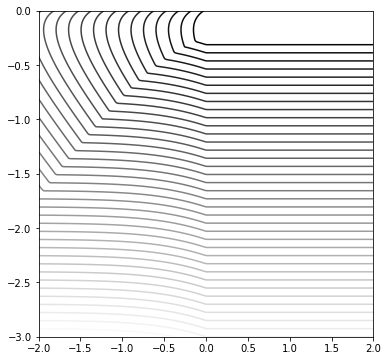

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


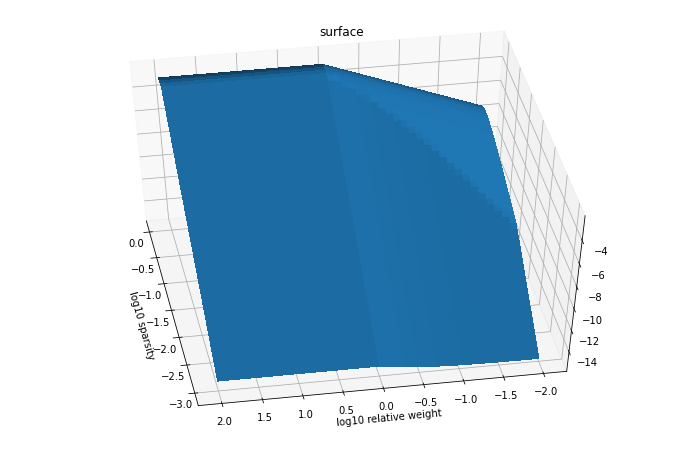

In [ ]:
# Calculate least loss among the explicit models.
least_explicit_loss = np.min(explicit_loss, axis=2)
log_least_explicit_loss = np.log(least_explicit_loss)

# make data
levels = np.linspace(log_least_explicit_loss.min(), log_least_explicit_loss.max(), 40)

# plot
fig, ax = plt.subplots()
fig.set_size_inches((6, 6))
ax.contour(log_weights, log_sparsities, log_least_explicit_loss, levels=levels, cmap="binary")
plt.show()


# Plot this loss.
plt.figure(figsize=(12, 8))
plt.title("Least loss among explicit models")

ax = plt.axes(projection='3d')
ax.set_xlabel("log10 sparsity")
ax.set_ylabel("log10 relative weight")
ax.view_init(50, 170)
ax.plot_surface(log_sparsities, log_weights, log_least_explicit_loss, linewidth=0, antialiased=False)
ax.set_title('surface');

# Show losses of individual functions.

Loss of $f$ (which just ignores last coordinate) is largely controlled by relative weight factor. Sparsity does make a small difference since it affects how often the last coordinate is nonzero, hence how often relative weight factor matters.

Loss of $h$ (which preserves last coordinate) is controlled by sparsity. Relative weight mathematically makes no difference.

Loss of $g$ is a more complicated function of relative weight and sparsity.

_Reminder_: we only calculate loss on nonzero vectors, so the distribution of test data is conditional on the vector being nonzero. For very small sparsity values, that means we're mostly testing on vectors with exactly one nonzero coordinate.


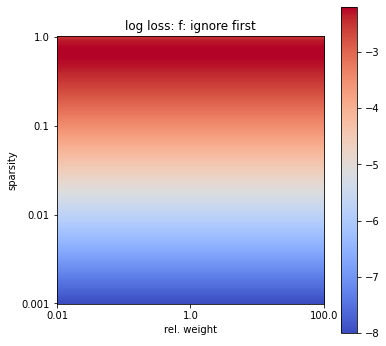

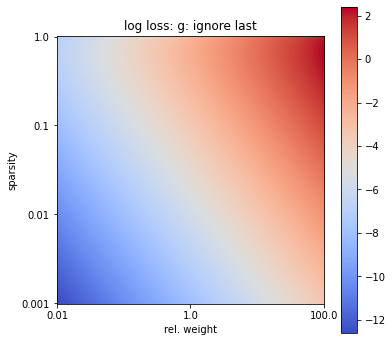

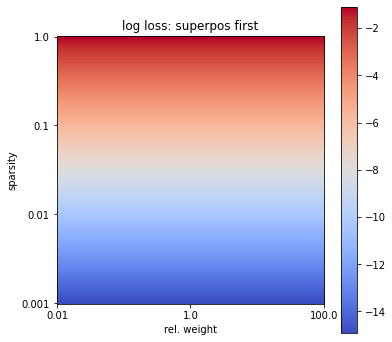

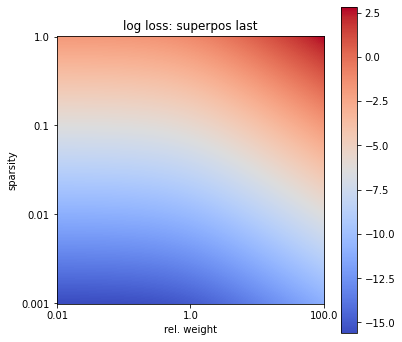

In [ ]:
# Show matrix the normal way, with color bar rather than legend
def show_matrix(matrix, cmap, norm, title):
  plt.figure(figsize=(6, 6))
  plt.title(title)
  heatmap = plt.imshow(matrix, cmap=cmap, norm=norm)
  add_log_ticks()
  plt.colorbar(heatmap)
  plt.show()

# Plot log losses of each individual function
cmap = plt.get_cmap('coolwarm')
for i in range(4):
  show_matrix(np.log(explicit_loss[:,:,i]), cmap, colors.Normalize(), 'log loss: ' + function_labels[i])



# Plot differences between log losses

If we plot the differences between log losses (equiv., log of ratios of losses) for each pair of functions, we see how the phase portrait is constructed.

One interesting point is that superposition of the last coordinates has only a small advantage over superposing the first coordinates, even when the relative weight is less than one. Be careful in interpreting the color scale, which is normalized differently on both sides of zero. This is slightly tricky to read, but it makes it much easier to see the tiny difference between $g$ and $h$.

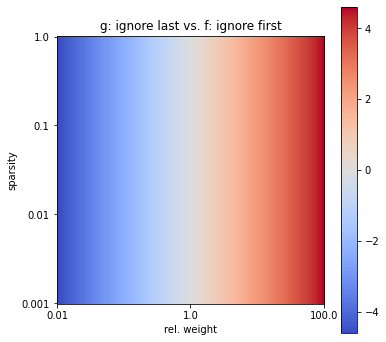

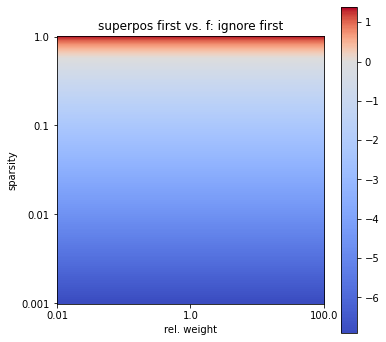

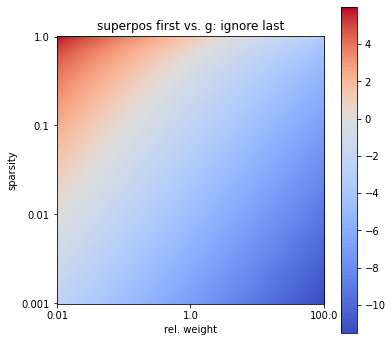

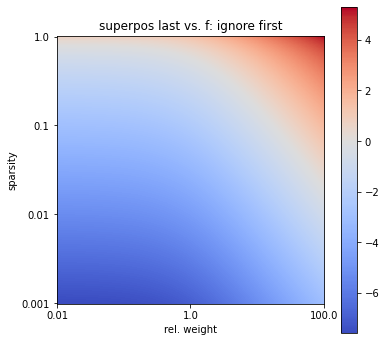

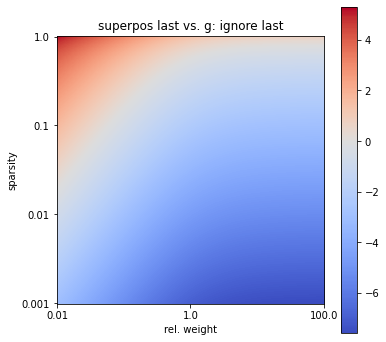

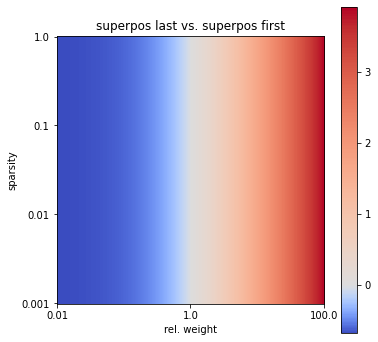

In [ ]:

# Plot log ratios of losses
cmap = plt.get_cmap('coolwarm')
for i in range(4):
  for j in range(i):
    show_matrix(np.log(explicit_loss[:,:,i]) - np.log(explicit_loss[:,:,j]), cmap, colors.TwoSlopeNorm(0), function_labels[i] + " vs. " + function_labels[j])
